In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Lambda,Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Sequential  #用來啟動 NN
from tensorflow.keras.layers import Conv2D  # Convolution Operation
from tensorflow.keras.layers import MaxPooling2D # Pooling
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense # Fully Connected Networks
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate, AveragePooling2D, UpSampling2D, add, Multiply, GlobalAveragePooling2D
import tensorflow.keras as keras  
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import os
import random
import re
import time
from random import shuffle

In [2]:
from PIL import Image
import numpy as np
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2
batch_size = 12
img_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255
                            ,rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                              )
img_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,)
#輸入Train data Path
Train_path = 'D:/farm_data/Train_RGB_500/'
#輸入Valid data Path
Valid_path = 'D:/farm_data/Valid_RGB_500/'
images_Train = img_train.flow_from_directory(Train_path,target_size=(500,500),color_mode='rgb' ,
                      batch_size=batch_size,)
images_valid = img_valid.flow_from_directory(Valid_path,target_size=(500,500),color_mode='rgb' ,
                      batch_size=batch_size)

Found 64210 images belonging to 14 classes.
Found 16060 images belonging to 14 classes.


In [3]:
def squeeze_excitation(out_dim, nb_filter):
    def f(input):
        squeeze = GlobalAveragePooling2D()(input)
        excitation = Dense(int(out_dim/2), activation='relu')(squeeze)
        excitation = Dense(out_dim, activation='sigmoid')(excitation)
        excitation = Reshape((1,1,out_dim))(excitation)
        return Multiply()([input, excitation])
    return f


def squeeze_excitation_layer(out_dim, nb_filter):
    def f(input):
        input = squeeze_excitation(out_dim, nb_filter)(input)
        return input
    return f

In [4]:
def Conv2D_BN(inputs,filter,kernel,padding,stride):
    outputs = keras.layers.Conv2D(filters=filter,kernel_size=kernel,padding=padding,strides=stride,activation='relu')(inputs)
    outputs = keras.layers.BatchNormalization()(outputs)
    return outputs
def Stem(inputs):
    x = Conv2D_BN(inputs,32,(3,3),'valid',2)
    x = Conv2D_BN(x,32,(3,3),'valid',1)
    x =Conv2D_BN(x,64,(3,3),'same',1)
    x_cov = Conv2D_BN(x,96,(3,3),'valid',2)
    x_maxpooling = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="valid")(x)
    x = concatenate([x_cov, x_maxpooling])
    x_left = Conv2D_BN(x,32,(3,3),'same',1)
    x_left = Conv2D_BN(x_left,64,(7,1),'same',1)
    x_left = Conv2D_BN(x_left,64,(1,7),'same',1)
    x_left = Conv2D_BN(x_left,96,(3,3),'valid',1)
    x_right = Conv2D_BN(x,64,(1,1),'same',1)
    x_right = Conv2D_BN(x_right,96,(3,3),'valid',1)
    x = concatenate([x_left, x_right])
    #x = squeeze_excitation_layer(x.shape[-1], x.shape[-1])(x)
    x_cov = Conv2D_BN(x,192,(3,3),'valid',2)
    x_maxpooling = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="valid")(x)
    x = concatenate([x_cov, x_maxpooling])
    return x
def Inception_ResNet_A(inputs):
    x_1 = Conv2D_BN(inputs,32,(1,1),'same',1)
    x_2 = Conv2D_BN(inputs,32,(1,1),'same',1)
    x_2 = Conv2D_BN(x_2,32,(1,1),'same',1)
    x_3 = Conv2D_BN(inputs,32,(1,1),'same',1)
    x_3 =Conv2D_BN(x_3,48,(3,3),'same',1)
    x_3 =Conv2D_BN(x_3,64,(3,3),'same',1)
    x = concatenate([x_1, x_2, x_3])
    x = squeeze_excitation_layer(x.shape[-1], x.shape[-1])(x)
    outputs = keras.layers.Conv2D(filters=384,kernel_size=(1,1),padding='same',strides=1,activation='linear')(x)
    outputs = keras.layers.BatchNormalization()(outputs)
    outputs = keras.layers.add([outputs,inputs])
    return outputs
def Inception_ResNet_B(inputs):
    x_1 = Conv2D_BN(inputs,128,(1,1),'same',1)
    x_1 = Conv2D_BN(x_1,160,(1,7),'same',1)
    x_1 = Conv2D_BN(x_1,192,(7,1),'same',1)
    x_2 = Conv2D_BN(inputs,192,(1,1),'same',1)
    x = concatenate([x_1, x_2])
    x = squeeze_excitation_layer(x.shape[-1], x.shape[-1])(x)
    outputs = keras.layers.Conv2D(filters=1152,kernel_size=(1,1),padding='same',strides=1,activation='linear')(x)
    outputs = keras.layers.add([outputs,inputs])
    return outputs
def Inception_ResNet_C(inputs):
    x_1 = Conv2D_BN(inputs,192,(1,1),'same',1)
    x_1 = Conv2D_BN(x_1,224,(1,7),'same',1)
    x_1 = Conv2D_BN(x_1,256,(7,1),'same',1)
    x_2 = Conv2D_BN(inputs,192,(1,1),'same',1)
    x = concatenate([x_1, x_2])
    x = squeeze_excitation_layer(x.shape[-1], x.shape[-1])(x)
    outputs = keras.layers.Conv2D(filters=2048,kernel_size=(1,1),padding='same',strides=1,activation='linear')(x)
    x = squeeze_excitation_layer(x.shape[-1], x.shape[-1])(x)
    outputs = keras.layers.add([outputs,inputs])
    return outputs
def Reduction_A(inputs):
    x_1 = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="valid")(inputs)
    x_2 = Conv2D_BN(inputs,384,(3,3),'valid',2)
    x_3 = Conv2D_BN(inputs,256,(1,1),'same',1)
    x_3 =Conv2D_BN(x_3,256,(3,3),'same',1)
    x_3 =Conv2D_BN(x_3,384,(3,3),'valid',2)
    x = concatenate([x_1, x_2, x_3])
    return x
def Reduction_B(inputs):
    x_1 = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="valid")(inputs)
    x_2 = Conv2D_BN(inputs,256,(1,1),'same',1)
    x_2 = Conv2D_BN(x_2,320,(3,3),'valid',2)
    x_3 = Conv2D_BN(inputs,256,(1,1),'same',1)
    x_3 = Conv2D_BN(x_3,256,(3,3),'valid',2)
    x_4 = Conv2D_BN(inputs,256,(1,1),'same',1)
    x_4 =Conv2D_BN(x_4,288,(3,3),'same',1)
    x_4 =Conv2D_BN(x_4,320,(3,3),'valid',2)
    x = concatenate([x_1, x_2, x_3, x_4])
    print(x)
    return x

In [5]:
def ResNet_V2_SE():
    inputs = keras.Input(shape=(500,500,3))
    x = Stem(inputs)
    for i in range(5):
        x = Inception_ResNet_A(x)
    x = Reduction_A(x)
    for i in range(10):
        x = Inception_ResNet_B(x)
    x = Reduction_B(x)
    for i in range(5):
        x = Inception_ResNet_C(x)
    x = GlobalAveragePooling2D()(x) 
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(14,activation='softmax')(x)
    model = keras.Model(inputs=inputs,outputs=x)
    model.summary()
    return model

In [6]:
#Model
model=ResNet_V2_SE()

KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 2048), dtype=tf.float32, name=None), name='concatenate_19/concat:0', description="created by layer 'concatenate_19'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 249, 249, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 249, 249, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)    

In [11]:
#輸入model儲存的位置與名稱
checkpoint_filepath = 'D:/farm_data/model/Restnet_V2_SE_RGB_500(class 14).h5'
model_checkpoint_callback=ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
histroy=model.fit(images_Train,
          steps_per_epoch = int(64210/batch_size),
          validation_steps = int(16060/batch_size),
          validation_data = images_valid,
          epochs = 100,
          callbacks = [model_checkpoint_callback]
          )

Epoch 1/100
5350/5350 [==============================] - 1790s 333ms/step - loss: 0.0618 - accuracy: 0.9869 - val_loss: 7.4122 - val_accuracy: 0.9686

Epoch 00001: val_accuracy improved from -inf to 0.96861, saving model to D:/farm_data/model\Restnet_V2_SE_RGB_500(class 14)100_200.h5


C:\Users\USER\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
5350/5350 [==============================] - 1781s 333ms/step - loss: 0.0603 - accuracy: 0.9876 - val_loss: 11.7336 - val_accuracy: 0.9715

Epoch 00002: val_accuracy improved from 0.96861 to 0.97154, saving model to D:/farm_data/model\Restnet_V2_SE_RGB_500(class 14)100_200.h5
Epoch 3/100
5350/5350 [==============================] - 1788s 334ms/step - loss: 0.0566 - accuracy: 0.9878 - val_loss: 0.5605 - val_accuracy: 0.9758

Epoch 00003: val_accuracy improved from 0.97154 to 0.97583, saving model to D:/farm_data/model\Restnet_V2_SE_RGB_500(class 14)100_200.h5
Epoch 4/100
5350/5350 [==============================] - 1770s 331ms/step - loss: 0.0595 - accuracy: 0.9873 - val_loss: 0.5043 - val_accuracy: 0.9803

Epoch 00004: val_accuracy improved from 0.97583 to 0.98026, saving model to D:/farm_data/model\Restnet_V2_SE_RGB_500(class 14)100_200.h5
Epoch 5/100
5350/5350 [==============================] - 1771s 331ms/step - loss: 0.0587 - accuracy: 0.9874 - val_loss: 1190.5380 - val

KeyboardInterrupt: 

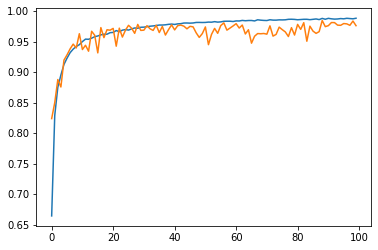

In [9]:
import matplotlib.pyplot as plt
plt.plot(histroy.history['accuracy']) 
plt.plot(histroy.history['val_accuracy']) 